# Project: Portfolio - Final Project

## Objectives
Developed and trained a model for Alzheimer's MRI classification employing two distinct methods:

1. Constructed a model utilizing the ResNet18 architecture.
2. Employed transfer learning techniques to train the model effectively.

## Model Objectives
1. The main purpose of this model is for early detection of Alzheimer's disease using MRI (Magnetic Resonance Imaging) scans. Early detection is crucial for timely treatment and care, thus slowing down the progression of the disease.
2. This model can serve as a reliable tool for healthcare professionals to assist in the diagnosis of Alzheimer's.

## Description of the model

1. The dataset used in this project is <code>Falah/Alzheimer_MRI</code> taken from HuggingFace. This dataset contains MRI results of the brain consisting of 4 labels.

2. Task: Image Classification

3. The pretrained model used in this project for transfer learning technique is <code>google/vit-base-patch16-224-in21k</code>


## Working Space

### Load dataset

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install datasets
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import numpy as np
from PIL import Image
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.models import resnet18

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
dataset = load_dataset("Falah/Alzheimer_MRI", split='train')

print("Number of examples:", len(dataset))
print("Sample data:")
for example in dataset[:5]:
    print(example)

dataset = dataset.train_test_split(test_size=0.2)
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Number of examples: 5120
Sample data:
image
label


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4096
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1024
    })
})

In [ ]:
# label mapping
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
label2id

{'Mild_Demented': '0',
 'Moderate_Demented': '1',
 'Non_Demented': '2',
 'Very_Mild_Demented': '3'}

In [ ]:
id2label

{'0': 'Mild_Demented',
 '1': 'Moderate_Demented',
 '2': 'Non_Demented',
 '3': 'Very_Mild_Demented'}

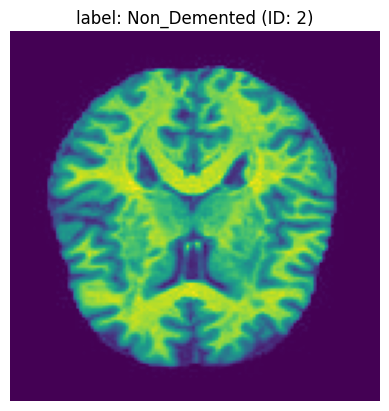

In [ ]:
# define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# use the first training example
image = dataset["train"][0]['image']
label_id = str(dataset["train"][0]['label'])
label_name = id2label_view[label_id]

# display the image and its corresponding label
plt.imshow(image)
plt.title(f'label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

#preprocess

In [ ]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def transforms(examples):
    # Convert images to RGB and apply transformations
    examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]

    # Stack the list of tensors into a single tensor
    examples["pixel_values"] = torch.stack(examples["pixel_values"])


    # Remove the original image data
    del examples["image"]

    return examples


In [ ]:
dataset.set_transform(transforms)

In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
print(train_dataset[0].keys())

dict_keys(['label', 'pixel_values'])


In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 4096
})

In [ ]:
train_dataset[0]

{'label': 2,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

# **1. BUILD AND TRAIN MODEL USING RESNET18**

# Build and Train the Model

In [ ]:
# define the model
model = resnet18(pretrained=True)

# Modify the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# use data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.1MB/s]


In [ ]:
train_loader.dataset[0]

{'label': 2,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

In [ ]:
test_loader.dataset[0]

{'label': 2,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

In [ ]:
num_epochs = 4
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # extract images and labels
        images, labels = data['pixel_values'], data['label']
        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        # print the statistics
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # test the model
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            images, labels = data['pixel_values'], data['label']
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print teh accuracy
    print('Epoch [{}/{}], Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, 100 * correct / total))

Epoch [1/4], Batch [100/128], Loss: 0.2145
Epoch [1/4], Test Accuracy: 84.77%
Epoch [2/4], Batch [100/128], Loss: 0.0740
Epoch [2/4], Test Accuracy: 90.14%
Epoch [3/4], Batch [100/128], Loss: 0.0270
Epoch [3/4], Test Accuracy: 90.72%
Epoch [4/4], Batch [100/128], Loss: 0.0169
Epoch [4/4], Test Accuracy: 90.82%


In [ ]:
accuracy = 100*correct/total
accuracy

90.8203125

In [ ]:
# save model
torch.save(model.state_dict(), 'resnet18_alzheimer_classifier.pth')
print('Model saved!')

Model saved!


# **2. TRANSFER LEARNING**

## Preprocess

In [ ]:
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
# define the tranform
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortedt_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
# define the tranformation function
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
# apply the tranformation function
dataset = dataset.with_transform(transforms)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4096
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1024
    })
})

In [ ]:
print(dataset["train"][0].keys())

dict_keys(['label', 'pixel_values'])


In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    # ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Setup

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/alzheimer_mri_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.834463,0.599609
2,No log,0.824488,0.630859
3,No log,0.749202,0.654297
4,0.818800,0.717307,0.677734
5,0.818800,0.662493,0.716797
6,0.818800,0.618235,0.737305
7,0.818800,0.505812,0.802734
8,0.534400,0.556721,0.776367
9,0.534400,0.470234,0.819336
10,0.534400,0.450235,0.824219


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.834463,0.599609
2,No log,0.824488,0.630859
3,No log,0.749202,0.654297
4,0.818800,0.717307,0.677734
5,0.818800,0.662493,0.716797
6,0.818800,0.618235,0.737305
7,0.818800,0.505812,0.802734
8,0.534400,0.556721,0.776367
9,0.534400,0.470234,0.819336
10,0.534400,0.450235,0.824219


TrainOutput(global_step=1920, training_loss=0.49200644890467327, metrics={'train_runtime': 2552.0775, 'train_samples_per_second': 24.075, 'train_steps_per_second': 0.752, 'total_flos': 4.761193186527805e+18, 'train_loss': 0.49200644890467327, 'epoch': 15.0})

In [ ]:
eval_result = trainer.evaluate(eval_dataset=dataset["test"])
print(eval_result)

accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])
accuracy_str

{'eval_loss': 0.34043994545936584, 'eval_accuracy': 0.876953125, 'eval_runtime': 15.3391, 'eval_samples_per_second': 66.758, 'eval_steps_per_second': 2.086, 'epoch': 15.0}


'0.8770'

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1711340865.f217d2df06e1.2044.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dewifaj/alzheimer_mri_classification/commit/37bb2208a3e8171e9c155f2b67722b1f25b3531b', commit_message='End of training', commit_description='', oid='37bb2208a3e8171e9c155f2b67722b1f25b3531b', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
from transformers import pipeline
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

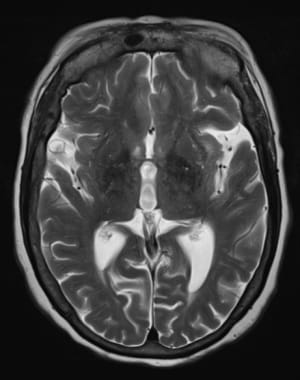

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

[{'label': 'Very_Mild_Demented', 'score': 0.8166950941085815},
 {'label': 'Non_Demented', 'score': 0.11395150423049927},
 {'label': 'Mild_Demented', 'score': 0.03971049562096596},
 {'label': 'Moderate_Demented', 'score': 0.029642848297953606}]

In [ ]:
img_url = "https://img.medscapestatic.com/pi/meds/ckb/26/303926tn.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

display(img)

classifier = pipeline(model="dewifaj/alzheimer_mri_classification")
classifier(img_url)

# Build an App with Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from transformers import pipeline
def alz_mri_classification(image):
    classifier = pipeline("image-classification", model="dewifaj/alzheimer_mri_classification")
    result = classifier(image)
    # extract the highest score
    prediction = result[0]
    score = prediction['score']
    label = prediction['label']
    return {"score": score, "label": label}

image_input = gr.Image(type="pil", label="Upload Image")
iface = gr.Interface(fn=alz_mri_classification, inputs=image_input, outputs="json", title="Alzheimer Recognition from MRI")
iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://77447a787e6a7dfb52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://77447a787e6a7dfb52.gradio.live


## Submit Notebook

# FIN